<a href="https://colab.research.google.com/github/LucasHLirio/TCC_II/blob/main/chebloss_CNN_BO_MNIST_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Install and import the Keras Tuner:

In [ ]:
import tensorflow as tf
from tensorflow import keras

!pip install -q -U keras-tuner
import keras_tuner as kt

Test the GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Download and prepare the dataset



In [ ]:
from keras.utils import to_categorical

(img_train, label_train), (img_test, label_test) = keras.datasets.mnist.load_data(path="mnist.npz")

#Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# One-hot encode labels for categorical crossentropy function
label_train = to_categorical(label_train, num_classes=10)
label_test = to_categorical(label_test, num_classes=10)

##Create the custom loss function

In [ ]:
from keras import losses
class ChebyshevLoss(losses.Loss):
    def __init__(self, ideal_loss_point, weights, name="chebyshev_loss"):
        super().__init__(name=name)
        self.ideal_loss_point = ideal_loss_point
        self.weights = weights

    def call(self, y_true, y_pred):
        # Calculates cross entropy loss (error)
        error_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)

        # Calculates L2 regularization (complexity)
        l2_loss = tf.add_n([tf.nn.l2_loss(weight) for weight in self.model.trainable_weights])

        # Chebyshev Scalarization involves maximizing the minimum of weights
        # Chebyshev loss is essentially the largest weighted difference of each objective to the ideal points
        weighted_error_diff = self.weights[0] * (error_loss - self.ideal_loss_point[0])
        weighted_l2_diff = self.weights[1] * (l2_loss - self.ideal_loss_point[1])

        # Combining the loss components following the Chebyshev criterion
        chebyshev_loss = tf.maximum(weighted_error_diff, weighted_l2_diff)

        return chebyshev_loss

    def get_config(self):
        config = super(ChebyshevLoss, self).get_config()
        config.update({
            "ideal_loss_point": self.ideal_loss_point,
            "weights": self.weights
        })
        return config

##Build the model

In [ ]:
def model_builder(hp):
  # Defining the scope of the Hyperparameters:----------------------------------

  # convolutional layers
  hp_conv1_units = hp.Int('conv1_units', min_value=32, max_value=512, step=32)
  hp_conv2_units = hp.Int('conv2_units', min_value=32, max_value=512, step=32)
  hp_conv3_units = hp.Int('conv3_units', min_value=32, max_value=512, step=32)

  hp_kernel_size1 =  hp.Int('kern_size1', min_value=3, max_value=5)
  hp_kernel_size2 =  hp.Int('kern_size2', min_value=3, max_value=5)
  hp_kernel_size3 =  hp.Int('kern_size3', min_value=3, max_value=5)

  hp_pool_size1 = hp.Int('pool_sz1', min_value=2, max_value=4)
  hp_pool_size2 = hp.Int('pool_sz2', min_value=2, max_value=4)
  hp_pool_size3 = hp.Int('pool_sz3', min_value=2, max_value=4)

  hp_stride_conv1 = hp.Int('stride_conv1', min_value=1, max_value=5)
  hp_stride_conv2 = hp.Int('stride_conv2', min_value=1, max_value=5)
  hp_stride_conv3 = hp.Int('stride_conv3', min_value=1, max_value=5)

  hp_stride_pool1 = hp.Int('stride_pool1', min_value=1, max_value=5)
  hp_stride_pool2 = hp.Int('stride_pool2', min_value=1, max_value=5)
  hp_stride_pool3 = hp.Int('stride_pool3', min_value=1, max_value=5)

  # dense layers
  hp_activation=hp.Choice('activation', values=['relu','tanh','sigmoid'])

  hp_dense_units1 = hp.Int('dense_units1', min_value=32, max_value=512, step=32)
  hp_dense_units2 = hp.Int('dense_units2', min_value=32, max_value=512, step=32)

  hp_dropout_rate1 = hp.Choice('dropout_rate1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
  hp_dropout_rate2 = hp.Choice('dropout_rate2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

  #defining the optimizer and it's learning rate
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3])
  optimizer = tf.keras.optimizers.get(hp_optimizer)
  optimizer.learning_rate = hp_learning_rate


  #Building the model:----------------------------------------------------------

  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(28, 28, 1))),

  model.add(keras.layers.Conv2D(hp_conv1_units, kernel_size=(hp_kernel_size1), strides=(hp_stride_conv1), padding='same')), # conv1
  model.add(keras.layers.MaxPooling2D(pool_size=(hp_pool_size1), strides=(hp_stride_pool1), padding='same')), # max pool 1
  model.add(keras.layers.Conv2D(hp_conv2_units, kernel_size=(hp_kernel_size2), strides=(hp_stride_conv2), padding='same')), # conv2
  model.add(keras.layers.MaxPooling2D(pool_size=(hp_pool_size2), strides=(hp_stride_pool2), padding='same')), # max pool 2
  model.add(keras.layers.Conv2D(hp_conv3_units, kernel_size=(hp_kernel_size3), strides=(hp_stride_conv3), padding='same')), # conv3
  model.add(keras.layers.MaxPooling2D(pool_size=(hp_pool_size3), strides=(hp_stride_pool3), padding='same')), # max pool 3

  model.add(keras.layers.Flatten()) # flatten

  model.add(keras.layers.Dense(units=hp_dense_units1, activation=hp_activation)) # dense 1
  model.add(keras.layers.Dropout(hp_dropout_rate1)), # dropout 1

  model.add(keras.layers.Dense(units=hp_dense_units2, activation=hp_activation)) # dense 2
  model.add(keras.layers.Dropout(hp_dropout_rate2)), # dropout 2

  model.add(keras.layers.Dense(10)) # dense output

  #loss function hps
  hp_wheights1 = hp.Float('loss_wgt1', min_value=0.5, max_value=1.0, step=0.1)
  hp_wheights2 = hp.Float('loss_wgt2', min_value=0.0, max_value=0.5, step=0.1)

  ideal_loss_point = (0.0, 0.0)
  weights=(hp_wheights1, hp_wheights2)

  custom_loss_cheb = ChebyshevLoss(ideal_loss_point=ideal_loss_point, weights=weights)
  custom_loss_cheb.model = model #associates the model with the custom loss object

  model.compile(optimizer=optimizer,
                loss=custom_loss_cheb,
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hypertuning
In this case we use the Bayesian Optimization method

In [ ]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=50,
    directory='my_dir_test',
    project_name='closs_cnn',
    overwrite=True) #overwrites an older saved project

Create a callback to stop training early after reaching a certain value for the validation loss.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search

In [ ]:
import time
start = time.time() # will measure the searching duration

tuner.search(img_train, label_train, epochs=10, validation_split=0.4, callbacks=[stop_early]) # run the HP search

Trial 50 Complete [00h 02m 34s]
val_accuracy: 0.10954166948795319

Best val_accuracy So Far: 0.9760416746139526
Total elapsed time: 01h 41m 51s


In [ ]:
end = time.time()
search_duration = (end-start)/60

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

## Train the model

In [ ]:
# Build the model with the optimal HPs and train it

hypermodel = tuner.hypermodel.build(best_hps)

fit_start = time.time()
history = hypermodel.fit(img_train, label_train, epochs=100, validation_split=0.4)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'\nBest epoch:{best_epoch}')

Epoch 1/100
1125/1125 [==============================] - 10s 8ms/step - loss: 0.1858 - accuracy: 0.9193 - val_loss: 0.0795 - val_accuracy: 0.9663
Epoch 2/100
1125/1125 [==============================] - 8s 7ms/step - loss: 0.0902 - accuracy: 0.9624 - val_loss: 0.0707 - val_accuracy: 0.9709
Epoch 3/100
1125/1125 [==============================] - 7s 7ms/step - loss: 0.0815 - accuracy: 0.9654 - val_loss: 0.0597 - val_accuracy: 0.9763
Epoch 4/100
1125/1125 [==============================] - 7s 6ms/step - loss: 0.0756 - accuracy: 0.9676 - val_loss: 0.0659 - val_accuracy: 0.9722
Epoch 5/100
1125/1125 [==============================] - 8s 7ms/step - loss: 0.0759 - accuracy: 0.9681 - val_loss: 0.0634 - val_accuracy: 0.9754
Epoch 6/100
1125/1125 [==============================] - 8s 7ms/step - loss: 0.0760 - accuracy: 0.9683 - val_loss: 0.0641 - val_accuracy: 0.9741
Epoch 7/100
1125/1125 [==============================] - 9s 8ms/step - loss: 0.0760 - accuracy: 0.9686 - val_loss: 0.0720 - val_a

In [ ]:
fit_end = time.time()
fit_duration = (fit_end-fit_start)/60

##Evaluate the Hypermodel

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0969 - accuracy: 0.9579


##Plot loss and accuracy curves

Text(0.5, 1.0, 'Loss Curves')

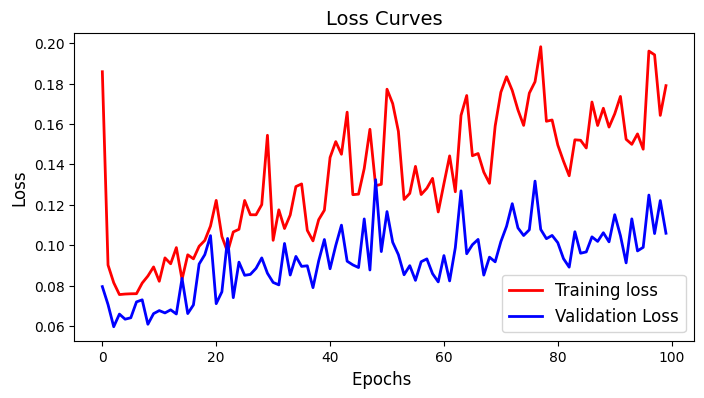

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[8,4])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=14)

Text(0.5, 1.0, 'Accuracy Curves')

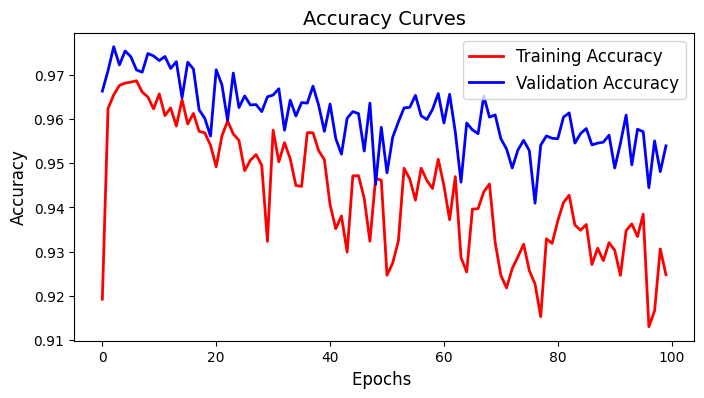

In [ ]:
plt.figure(figsize=[8,4])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves',fontsize=14)

##Summary

In [ ]:
print(f"*Best Hyperparameters found:")
for key, value in best_hps.values.items():
 print(key,":",value)
print(f'\n*Hypermodel Evaluation:\nTest loss: {eval_result[0]:.3f} \nTest accuracy: {100*eval_result[1]:.2f} %')
print(f"\n*Execution times:\nHyperparameter searching time: {search_duration:.2f} minutes \nHypermodel training time: {fit_duration:.2f} minutes")

*Best Hyperparameters found:
conv1_units : 128
conv2_units : 96
conv3_units : 128
kern_size1 : 5
kern_size2 : 3
kern_size3 : 5
pool_sz1 : 2
pool_sz2 : 2
pool_sz3 : 2
stride_conv1 : 1
stride_conv2 : 2
stride_conv3 : 5
stride_pool1 : 2
stride_pool2 : 2
stride_pool3 : 5
activation : tanh
dense_units1 : 128
dense_units2 : 128
dropout_rate1 : 0.4
dropout_rate2 : 0.5
optimizer : adam
learning_rate : 0.001
loss_wgt1 : 0.7
loss_wgt2 : 0.0

*Hypermodel Evaluation:
Test loss: 0.097 
Test accuracy: 95.79 %

*Execution times:
Hyperparameter searching time: 101.85 minutes 
Hypermodel training time: 13.30 minutes


In [ ]:
# HPS:
# 'conv_units'
# 'dense_units'
# 'kernel_size'
# 'pool_size'
# 'strides'
# 'activation function'
# 'dropout_rate'
# 'optimizer'
# 'learning_rate'
# 'loss_wgt'